In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial.distance import cdist


import infrastructure as inf

device = inf.device

# Reading in the pretrained models

In [2]:
from Custom_ResNet18 import custom_resnet_18

models_dict = {}

max_superclass = 10

for i in range(0,max_superclass):
    for j in range(i+1,max_superclass):
        path = "results_training_run1/models/model_{}_{}.pt".format(i,j)
        models_dict[(i,j)] = custom_resnet_18(num_classes=10).to(device)
        models_dict[(i,j)].load_state_dict(torch.load(path, map_location=device))
        models_dict[(i,j)].eval()




In [3]:
len(models_dict)

45

# Clustering to Initialization Algorithms

## Sorting into buckets

We start by taking the 64 filters of the first model as the basis for our clustering. We then sort the filters for each model into the buckets based on their cosine similarity, but in such a way that in each round only 1 filters is added to a bucket. We then take the avg filter from each bucket and use it as the basis for the next layer of clustering. We repeat this process until we have 64 clusters.

In [ ]:
def calculate_cosine_similarity(cluster_group, vec):
    total_distance = 0

    for cluster_vec in cluster_group:
        
        # Reshape vectors to 2D arrays as required by cosine_similarity function
        vec1 = np.array(cluster_vec).reshape(1, -1)
        vec2 = np.array(vec).reshape(1, -1)

        # Calculate cosine similarity and convert to cosine distance
        similarity = cosine_similarity(vec1, vec2)
        distance = 1 - similarity

        # Since cosine_similarity returns a 2D array, we take the first element
        total_distance += distance[0][0]

    return total_distance

In [ ]:
from tqdm import tqdm

def get_custom_clustering_groups(filters_per_model, num_filters_per_model):
    filter_vectors = []
    
    num_models = len(filters_per_model)
    
    for idx, filters in enumerate(filters_per_model):
        
        filter_vectors.append([])

        for i in range(filters.shape[0]):
            # Flatten and normalize the filter
            filter_vec = filters[i].flatten()
            filter_vec /= np.linalg.norm(filter_vec)
            filter_vectors[idx].append(filter_vec)
            
    new_groups = [[] for _ in range(num_filters_per_model)]
    permutations = [[] for _ in range(num_models)]
    
    # Now we go through all models and assign filters in a greedy manner
    for i in tqdm(range(num_models)):
        model_filters = filter_vectors[i]
        used_indices = set()
        
        # We go through every group of the new clusters and assign the min distance vector from the next model to it
        for cluster_idx, cluster_group in enumerate(new_groups):
            min_distance = float('inf')
            selected_vector_idx = None
            
            for idx, vec in enumerate(model_filters):
                dist = calculate_cosine_similarity(cluster_group, vec)
                if dist < min_distance and idx not in used_indices:
                    min_distance = dist
                    selected_vector_idx = idx
            
            new_groups[cluster_idx].append(model_filters[selected_vector_idx])
            used_indices.add(selected_vector_idx)
            permutations[i].append(selected_vector_idx)

    return new_groups, permutations

In [ ]:
def custom_clustering(filters, num_input_channels, num_filters, kernel_size, include_permutations=False):
    
    clustered_groups, permutations = get_custom_clustering_groups(filters, num_filters)
    
    filter_vectors = np.array(clustered_groups)
    average_filters = [np.mean(np.array(vectors), axis=0) for vectors in filter_vectors]
    
    shaped_average_filters = np.array(average_filters).reshape((num_filters, num_input_channels, kernel_size, kernel_size))
    torch_shaped_average_filters = torch.tensor(shaped_average_filters, dtype=torch.float32).to(device)
    
    if include_permutations:
        return torch_shaped_average_filters, permutations
    else:
        return torch_shaped_average_filters

## K-Means

In [ ]:
def kmeans_clustering(filters, num_input_channels, num_filters, kernel_size):
    
    filter_vectors = []
        
    num_models = len(filters)
    
    for idx, model_filters in enumerate(filters):
        
        filter_vectors.append([])

        for i in range(model_filters.shape[0]):
            # Flatten and normalize the filter
            filter_vec = model_filters[i].flatten()
            filter_vec /= np.linalg.norm(filter_vec)
            filter_vectors[idx].append(filter_vec)
    
    filter_vectors = np.vstack(filter_vectors)
    kmeans = KMeans(n_clusters=num_filters, n_init='auto')
    cluster_labels = kmeans.fit_predict(filter_vectors)

    average_filters = []

    for cluster_num in range(num_filters):
        
        # Find indices where the cluster label matches the current cluster number
        indices = np.where(cluster_labels == cluster_num)[0]

        # Filters belonging to the current cluster
        cluster_filters = filter_vectors[indices]

        # Compute the average filter for this cluster
        average_filter = np.mean(cluster_filters, axis=0)
        average_filters.append(average_filter)
        
    shaped_average_filters = np.array(average_filters).reshape((num_filters, num_input_channels, kernel_size, kernel_size))
    torch_shaped_average_filters = torch.tensor(shaped_average_filters, dtype=torch.float32).to(device)
    
    return torch_shaped_average_filters

## Permutation

In [ ]:
def permute_bias(permuted_model_bias, perm):
    permuted_model_bias.weight = torch.nn.Parameter(permuted_model_bias.weight[perm])
    permuted_model_bias.bias = torch.nn.Parameter(permuted_model_bias.bias[perm])
    permuted_model_bias.running_mean = permuted_model_bias.running_mean[perm]
    permuted_model_bias.running_var = permuted_model_bias.running_var[perm]

def permute_layer(permuted_layer, permuted_layer_next, permuted_bias, perm = None):
    if not perm is None: 
        permuted_layer.weight = torch.nn.Parameter(permuted_layer.weight[perm])
        permute_bias(permuted_bias, perm)
        permuted_layer_next.weight = torch.nn.Parameter(permuted_layer_next.weight.transpose(0,1)[perm].transpose(0,1))
    

def permute_weights(model, permutation):
    
     with torch.no_grad():
        permuted_model = copy.deepcopy(model)
        permute_layer(permuted_model.conv1, permuted_model.layer1[0].conv1, permuted_model.bn1, permutation)
        return permuted_model


## Model Initialization

### Custom Clustering


In [ ]:
def create_initialized_model_custom(models_dict):
    models = [model for model in models_dict.values()] 
    final_model = custom_resnet_18(num_classes=10).to(device)
    # completely copy the model so
    copied_model = custom_resnet_18(num_classes=10).to(device)
    copied_model.load_state_dict(final_model.state_dict())
    
    #Apply first layer clustering techniques
    trained_filters_layer1 = [model.conv1.weight.data.cpu().numpy() for model in models]
    sampled_filters_layer1, permutations = custom_clustering(filters=trained_filters_layer1,
                                               num_input_channels=3,
                                               num_filters=64,
                                               kernel_size=7,include_permutations=True)
    raise NotImplementedError("Need to implement permutation of weights")

    # Apply second layer clustering techniques
    trained_filters_layer2 = [model.layer1[0].conv1.weight.data.cpu().numpy() for model in models]
    sampled_filters_layer2 = custom_clustering(filters=trained_filters_layer2,
                                               num_input_channels=64,
                                               num_filters=64,
                                               kernel_size=3)
    
    final_model.conv1.weight.data = sampled_filters_layer1
    final_model.layer1[0].conv1.weight.data = sampled_filters_layer2
    
    return final_model, copied_model

### KMeans Clustering

In [ ]:
def create_initialized_model_kmeans(models_dict):
    models = [model for model in models_dict.values()] 
    final_model = custom_resnet_18(num_classes=10).to(device)
    # completely copy the model so
    copied_model = custom_resnet_18(num_classes=10).to(device)
    copied_model.load_state_dict(final_model.state_dict())
    
    #Apply first layer clustering techniques
    trained_filters_layer1 = [model.conv1.weight.data.cpu().numpy() for model in models]
    sampled_filters_layer1 = kmeans_clustering(filters=trained_filters_layer1,
                                               num_input_channels=3,
                                               num_filters=64,
                                               kernel_size=7)
    
    # Apply second layer clustering techniques
    trained_filters_layer2 = [model.layer1[0].conv1.weight.data.cpu().numpy() for model in models]
    sampled_filters_layer2 = kmeans_clustering(filters=trained_filters_layer2,
                                               num_input_channels=64,
                                               num_filters=64,
                                               kernel_size=3)
    
    # Apply third layer clustering techniques
    trained_filters_layer3 = [model.layer1[0].conv2.weight.data.cpu().numpy() for model in models]
    sampled_filters_layer3 = kmeans_clustering(filters=trained_filters_layer3,
                                               num_input_channels=64,
                                               num_filters=64,
                                               kernel_size=3)
    
    # Apply fourth layer clustering techniques
    trained_filters_layer4 = [model.layer1[1].conv1.weight.data.cpu().numpy() for model in models]
    sampled_filters_layer4 = kmeans_clustering(filters=trained_filters_layer4,
                                               num_input_channels=64,
                                               num_filters=64,
                                               kernel_size=3)
    
    # Apply fifth layer clustering techniques
    trained_filters_layer5 = [model.layer1[1].conv2.weight.data.cpu().numpy() for model in models]
    sampled_filters_layer5 = kmeans_clustering(filters=trained_filters_layer5,
                                               num_input_channels=64,
                                               num_filters=64,
                                               kernel_size=3)
    
    
    final_model.conv1.weight.data = sampled_filters_layer1
    final_model.layer1[0].conv1.weight.data = sampled_filters_layer2
    final_model.layer1[0].conv2.weight.data = sampled_filters_layer3
    final_model.layer1[1].conv1.weight.data = sampled_filters_layer4
    final_model.layer1[1].conv2.weight.data = sampled_filters_layer5
    
    return final_model, copied_model


# Experiments

## KMeans Clustering

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 40/40 [00:54<00:00,  1.35s/it]

plotting train loss: 1: [3.03366557 2.99787763 2.59472692 2.47261398 2.26832568 2.20358103
 2.09960862 2.00635653 1.98688678 1.92750282 1.89125368 1.89146596
 1.85330561 1.82610093 1.80586688 1.78003195 1.77736244 1.77156857
 1.74726431 1.7255272  1.71614712 1.70066521 1.67726701 1.6747873
 1.66051557 1.65973352 1.64082567 1.62780637 1.61828507 1.61283282
 1.61414326 1.59791951 1.59282354 1.58857112 1.58168511 1.58666972
 1.58247969 1.56907079 1.57359587 1.55818103] 2: [3.40071546 2.69715096 2.47921028 2.25834521 2.11064399 1.96706458
 1.90008529 1.79340788 1.7367232  1.67530321 1.69138976 1.62309689
 1.59818489 1.54153859 1.50900447 1.50430904 1.48420328 1.59779974
 1.54474187 1.48443747 1.46667379 1.45005208 1.42715915 1.398995
 1.38940655 1.34817585 1.33671883 1.33428769 1.31493343 1.29343502
 1.2823437  1.2401823  1.24304038 1.22913338 1.22155629 1.28845774
 1.27005256 1.20813466 1.20206432 1.19153124]
plotting val loss: 1: [6.54338747e+02 3.84820911e+00 5.15148628e+03 3.99640489e+

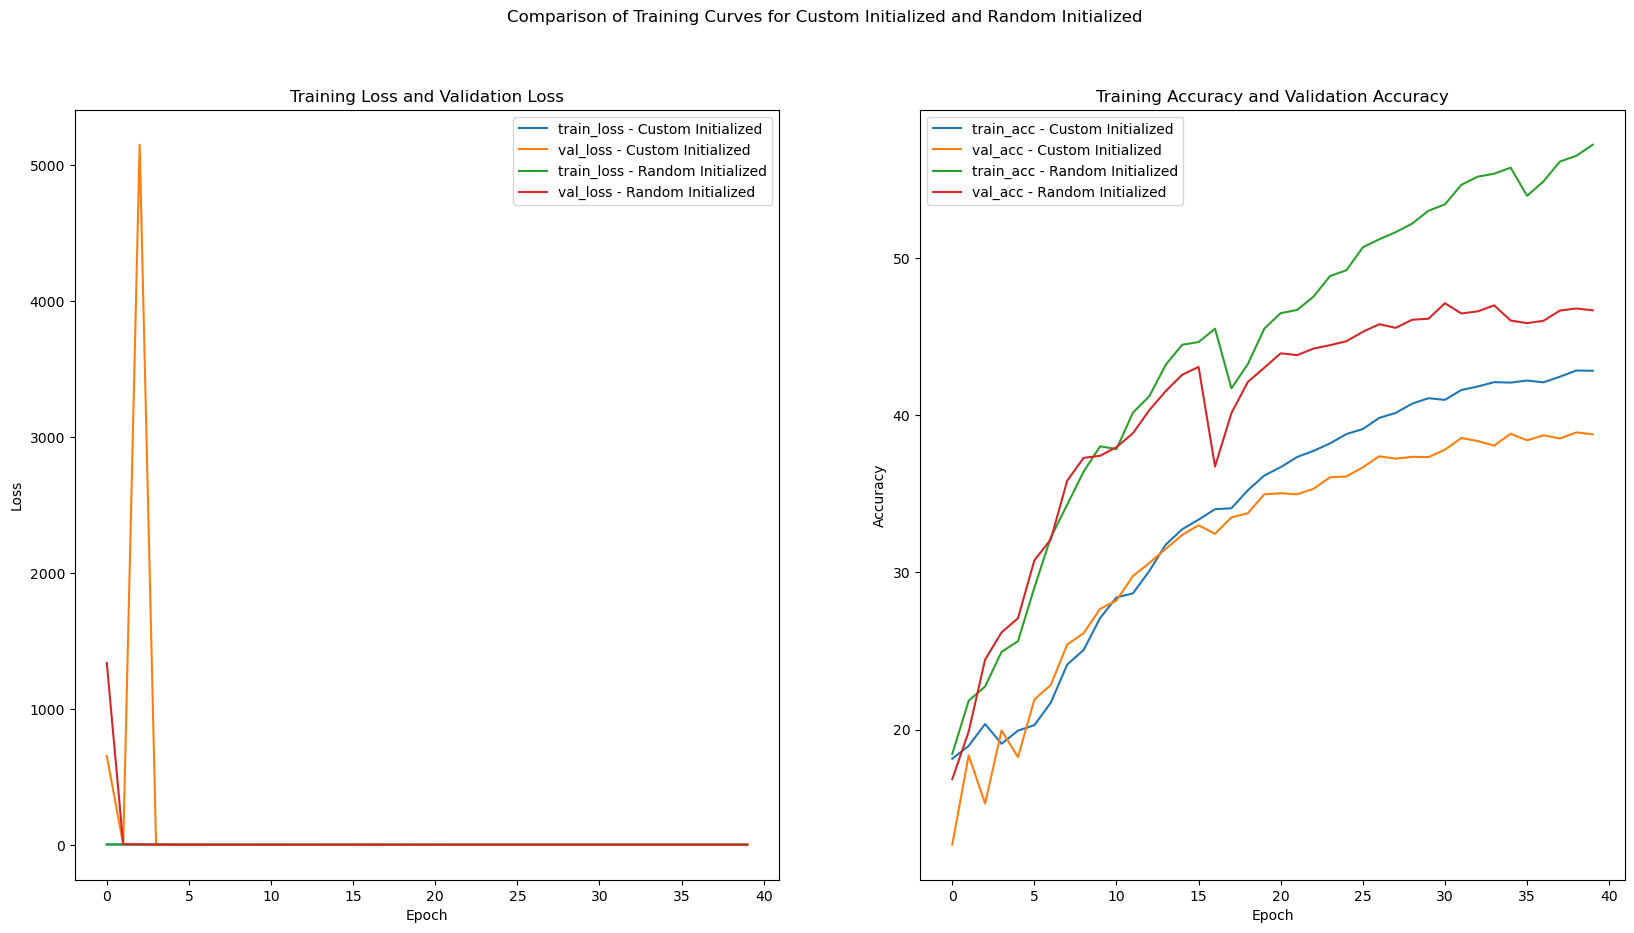

In [ ]:
tupels_to_test = [(10,11),(10,12),(10,13),(11,12),(11,13),(11,14)]
import time
tracked_custom_params = []
tracked_random_params = []

trials = 1

epochs = 40

# Pytorch MPS enabled
loaders_list = [inf.get_loaders_cifar100_superclass_subsets_pytorch(i,j,batch_size=128,num_workers=3) for i,j in tupels_to_test]

#data_sets_list = [inf.get_dataset_cifar100_superclass_subsets_pytorch(i,j) for i,j in tupels_to_test] 
## FFCV code: 
#loaders_list = [inf.get_loaders_cifar100_superclass_subsets_ffcv(i,j,batch_size=128,device=device) for i,j in tupels_to_test]

for loaders_mps in loaders_list:
    for i in range(trials):
        # this is ffcv artifact -> rewritte for pytorch dataloaders
        #paths =  [f'./data/subsets/{dataset_name}_superclass_{i}_{j}.beton' for dataset_name in ["train","test"]]
        #loaders, start_time = inf.make_dataloaders_ffcv(paths[0],paths[1],batch_size=128)
        
        start_time = time.time()
        
        #kmeans_clustered_model = custom_resnet_18(num_classes=10).to(device)
        #random_model = custom_resnet_18(num_classes=10).to(device)
        kmeans_clustered_model, _ = create_initialized_model_kmeans(models_dict)
        random_model = custom_resnet_18(num_classes=10).to(device)
        
        #inf.train_mps(kmeans_clustered_model,loaders_mps["train"],loaders_mps["test"],epochs,device)
        kmeans_model, tracked_custom = inf.train(kmeans_clustered_model, loaders_mps, epochs=epochs,lr=0.1, momentum=0.9, tracking_freq=1, reduce_factor=0.5, reduce_patience=5, do_tracking=True, early_stopping_min_epochs=80, early_stopping_patience=5, verbose=False,device=device)        
        r_model, tracked_random =  inf.train(random_model, loaders_mps, epochs=epochs,lr=0.1, momentum=0.9, tracking_freq=1, reduce_factor=0.5, reduce_patience=5, do_tracking=True, early_stopping_min_epochs=80, early_stopping_patience=5, verbose=False,device=device)        
        tracked_custom_params.append(tracked_custom)
        tracked_random_params.append(tracked_random)
        
        del r_model, kmeans_model, start_time, kmeans_clustered_model, random_model
        

# print out the average results

custom_params = inf.list_tracked_params_to_avg(tracked_custom_params)
random_params = inf.list_tracked_params_to_avg(tracked_random_params)

inf.plot_trainings(custom_params,random_params,"Custom Initialized","Random Initialized")

# 

## Clustering for RGB seperately

Each filters outputs are used for different filters in the next layer, these dependencies can be visualized as a graph. We start clustering on single 3d dimensional filters (for the first layer) and then having a prob distribution over the clusters for each filter in the next layer. We then use a pointer network to predict the cluster for each filter in the next layer.

(45, 64, 3, 7, 7)
(2880, 3, 7, 7)
(2880, 49)
{(0, 1): 4006.2255859375, (1, 1): 3892.27880859375, (2, 1): 3813.0390625, (0, 3): 2453.657958984375, (1, 3): 2495.026123046875, (2, 3): 2385.16455078125, (0, 5): 2185.547119140625, (1, 5): 2245.969970703125, (2, 5): 2118.21533203125, (0, 7): 2011.7086181640625, (1, 7): 2062.833740234375, (2, 7): 1954.172607421875, (0, 9): 1913.9095458984375, (1, 9): 1958.8148193359375, (2, 9): 1851.6588134765625, (0, 11): 1828.97509765625, (1, 11): 1879.864013671875, (2, 11): 1775.366455078125, (0, 13): 1766.08740234375, (1, 13): 1816.0675048828125, (2, 13): 1712.348876953125, (0, 15): 1719.368896484375, (1, 15): 1761.7325439453125, (2, 15): 1665.01708984375, (0, 17): 1686.762451171875, (1, 17): 1733.6412353515625, (2, 17): 1625.00048828125, (0, 19): 1645.6727294921875, (1, 19): 1705.781005859375, (2, 19): 1590.878173828125, (0, 21): 1624.62060546875, (1, 21): 1677.250244140625, (2, 21): 1568.3514404296875, (0, 23): 1598.990234375, (1, 23): 1635.27490234375,

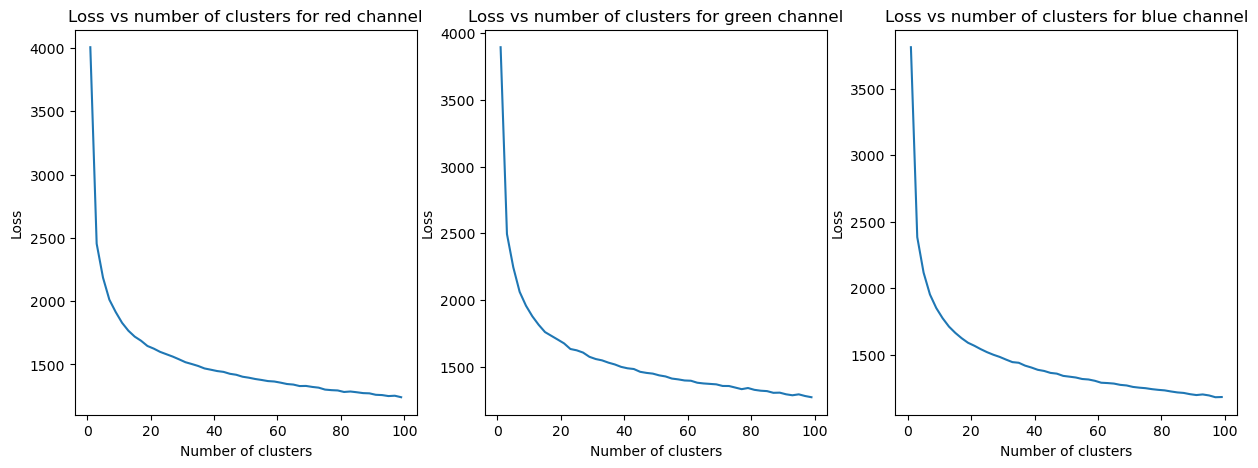

In [ ]:
import matplotlib.pyplot as plt

def clustering_kmeans(models):
    # go over all models and extract the first layer, and store it in a list
    first_layer_weights = []
    for model in models:
        first_layer_weights.append(models[model].conv1.weight.data.cpu().numpy())

    # flatten the list
    first_layer_weights = np.array(first_layer_weights)
    print(first_layer_weights.shape)
        
    # combine the first two dimensions of this np array
    first_layer_weights = first_layer_weights.reshape(-1, *first_layer_weights.shape[2:])
    print(first_layer_weights.shape)
    
    # flatten the list 
    filters_r = first_layer_weights[:,0,:,:]
    filters_r = filters_r.reshape(filters_r.shape[0],-1)
    filters_g = first_layer_weights[:,1,:,:]
    filters_g = filters_g.reshape(filters_g.shape[0],-1)
    filters_b = first_layer_weights[:,2,:,:]
    filters_b = filters_b.reshape(filters_b.shape[0],-1)

    print(filters_r.shape)

    # make this a list of values from 30 to 300 in steps of 10
    choices_num_clusters = list(range(1,100,2))

     # use elbow method to find the best number of clusters
    
    loss_list = {}

    for n_clusters in choices_num_clusters: 
        kmeans_r = KMeans(n_clusters=n_clusters, n_init='auto',)
        cluster_labels = kmeans_r.fit_predict(filters_r)
        loss_list[(0,n_clusters)] = kmeans_r.inertia_

        # repeat for green
        kmeans_g = KMeans(n_clusters=n_clusters, n_init='auto',)
        cluster_labels = kmeans_g.fit_predict(filters_g)
        loss_list[(1,n_clusters)] = kmeans_g.inertia_

        # repeat for blue
        kmeans_b = KMeans(n_clusters=n_clusters, n_init='auto',)
        cluster_labels = kmeans_b.fit_predict(filters_b)
        loss_list[(2,n_clusters)] = kmeans_b.inertia_


    print(loss_list)
    # make 1x3 plot to plot the loss for each color channel
    fig, axs = plt.subplots(1,3,figsize=(15,5))
    # plot the loss for red
    data_r = [loss_list[(0,n_clusters)] for n_clusters in choices_num_clusters]
    axs[0].plot(choices_num_clusters,data_r)
    # add y label
    axs[0].set_ylabel('Loss')
    # add x label
    axs[0].set_xlabel('Number of clusters')
    # add title
    axs[0].set_title('Loss vs number of clusters for red channel')

    # plot the loss for green
    data_g = [loss_list[(1,n_clusters)] for n_clusters in choices_num_clusters]
    axs[1].plot(choices_num_clusters,data_g)
    # add y label
    axs[1].set_ylabel('Loss')
    # add x label
    axs[1].set_xlabel('Number of clusters')
    # add title
    axs[1].set_title('Loss vs number of clusters for green channel')

    # plot the loss for blue
    data_b = [loss_list[(2,n_clusters)] for n_clusters in choices_num_clusters]
    axs[2].plot(choices_num_clusters,data_b)
    # add y label
    axs[2].set_ylabel('Loss')
    # add x label
    axs[2].set_xlabel('Number of clusters')
    # add title
    axs[2].set_title('Loss vs number of clusters for blue channel')

    plt.show()

    return


clusters = clustering_kmeans(models_dict)

# Clustering every filter seperately

In [3]:
len(models_dict)

def models_to_filter_per_layer(models_dict):
    models =  [model for model in models_dict.values()]

    filters_per_layer = {}
    
    filters_per_layer["0"] = []
    for model in models:
        filters_per_layer["0"].append(model.conv1.weight.data.cpu().numpy())
    
    filters_per_layer["1"] = []
    for model in models:
        filters_per_layer["1"].append(model.layer1[0].conv1.weight.data.cpu().numpy())
    
    filters_per_layer["2"] = []
    for model in models:
        filters_per_layer["2"].append(model.layer1[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["3"] = []
    for model in models:
        filters_per_layer["3"].append(model.layer1[1].conv1.weight.data.cpu().numpy())
    
    filters_per_layer["4"] = []
    for model in models:
        filters_per_layer["4"].append(model.layer1[1].conv2.weight.data.cpu().numpy())
    
    # do this for the rest of the layers until layer 4: 
    filters_per_layer["5"] = []
    for model in models:
        filters_per_layer["5"].append(model.layer2[0].conv1.weight.data.cpu().numpy())

    filters_per_layer["6"] = []
    for model in models:
        filters_per_layer["6"].append(model.layer2[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["7"] = []
    for model in models:
        filters_per_layer["7"].append(model.layer2[1].conv1.weight.data.cpu().numpy())

    filters_per_layer["8"] = []
    for model in models:
        filters_per_layer["8"].append(model.layer2[1].conv2.weight.data.cpu().numpy())

    filters_per_layer["9"] = []
    for model in models:
        filters_per_layer["9"].append(model.layer3[0].conv1.weight.data.cpu().numpy())

    filters_per_layer["10"] = []
    for model in models:
        filters_per_layer["10"].append(model.layer3[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["11"] = []
    for model in models:
        filters_per_layer["11"].append(model.layer3[1].conv1.weight.data.cpu().numpy())

    filters_per_layer["12"] = []
    for model in models:
        filters_per_layer["12"].append(model.layer3[1].conv2.weight.data.cpu().numpy())

    filters_per_layer["13"] = []
    for model in models:
        filters_per_layer["13"].append(model.layer4[0].conv1.weight.data.cpu().numpy())

    filters_per_layer["14"] = []
    for model in models:
        filters_per_layer["14"].append(model.layer4[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["15"] = []
    for model in models:
        filters_per_layer["15"].append(model.layer4[1].conv1.weight.data.cpu().numpy())

    filters_per_layer["16"] = []
    for model in models:
        filters_per_layer["16"].append(model.layer4[1].conv2.weight.data.cpu().numpy())

    for key in filters_per_layer.keys():
        filters_per_layer[key] = np.array(filters_per_layer[key])

    return filters_per_layer


def clustering_for_single_layer(filters_per_layer,layer_key, num_clusters):
    filters_per_layer[layer_key] = np.array(filters_per_layer[layer_key])
    # reshape every single filter to a 1d array
    #print(filters_per_layer[layer_key].shape)
    filters_per_layer[layer_key] = filters_per_layer[layer_key].reshape(-1, *filters_per_layer[layer_key].shape[3:])
    filters_per_layer[layer_key] = filters_per_layer[layer_key].reshape(filters_per_layer[layer_key].shape[0],-1)
    #print(filters_per_layer[layer_key].shape)
    # now it has the form #filters x #elements in filter (where 1 filter is one 2d array, stored as 1d)

    
    kmeans_filters = KMeans(n_clusters=num_clusters, n_init='auto',)
    cluster_labels = kmeans_filters.fit_predict(filters_per_layer[layer_key])
    
    # cluster centers:
    cluster_centers = kmeans_filters.cluster_centers_
    return cluster_labels, cluster_centers



def clustering_custom(models_dict,device, num_clusters=30):
    # get dict of filters for every layer
    filters_per_layer = models_to_filter_per_layer(models_dict)
    keys = list(filters_per_layer.keys())

    new_filters_per_layer = {}

    for layer_key in keys:
        num_3d_filters = filters_per_layer[layer_key].shape[1]

        #print(layer_key)
        orig_shape = filters_per_layer[layer_key].shape
        labels, centers = clustering_for_single_layer(filters_per_layer,layer_key,num_clusters)
        
        
        # create a prob density vector of the labels
        pdf = np.zeros(num_clusters)
        for i in range(labels.shape[0]):
            pdf[labels[i]] += 1
        pdf = pdf/labels.shape[0]
        

        
        #print("orig shape: ",orig_shape)
        #print(labels.shape)
        #print(centers.shape)
        # construct the vector of # filters x centroids 
        new_filters = np.zeros(orig_shape[1:])
        #print("new filters",new_filters.shape)    

        for i in range(new_filters.shape[0]):
            for j in range(new_filters.shape[1]):
                # sample an index from this pdf, this is the index of the cluster that we will use
                sampled_index = np.random.choice(num_clusters, p=pdf)
                #print(sampled_index)
                new_filters[i][j] = centers[sampled_index].reshape((new_filters.shape[2],new_filters.shape[3]))

        new_filters_per_layer[layer_key] = new_filters

     
        
    model = custom_resnet_18(num_classes=10).to(device)
    
    # go over all layers and set the new filters
    model.conv1.weight.data = torch.tensor(new_filters_per_layer["0"], dtype=torch.float32).to(device)
    model.layer1[0].conv1.weight.data = torch.tensor(new_filters_per_layer["1"], dtype=torch.float32).to(device)
    model.layer1[0].conv2.weight.data = torch.tensor(new_filters_per_layer["2"], dtype=torch.float32).to(device)
    # do this also for the rest of the layers:
    model.layer1[1].conv1.weight.data = torch.tensor(new_filters_per_layer["3"], dtype=torch.float32).to(device)
    model.layer1[1].conv2.weight.data = torch.tensor(new_filters_per_layer["4"], dtype=torch.float32).to(device)
    model.layer2[0].conv1.weight.data = torch.tensor(new_filters_per_layer["5"], dtype=torch.float32).to(device)
    model.layer2[0].conv2.weight.data = torch.tensor(new_filters_per_layer["6"], dtype=torch.float32).to(device)
    model.layer2[1].conv1.weight.data = torch.tensor(new_filters_per_layer["7"], dtype=torch.float32).to(device)
    model.layer2[1].conv2.weight.data = torch.tensor(new_filters_per_layer["8"], dtype=torch.float32).to(device)
    model.layer3[0].conv1.weight.data = torch.tensor(new_filters_per_layer["9"], dtype=torch.float32).to(device)
    model.layer3[0].conv2.weight.data = torch.tensor(new_filters_per_layer["10"], dtype=torch.float32).to(device)
    model.layer3[1].conv1.weight.data = torch.tensor(new_filters_per_layer["11"], dtype=torch.float32).to(device)
    model.layer3[1].conv2.weight.data = torch.tensor(new_filters_per_layer["12"], dtype=torch.float32).to(device)
    model.layer4[0].conv1.weight.data = torch.tensor(new_filters_per_layer["13"], dtype=torch.float32).to(device)
    model.layer4[0].conv2.weight.data = torch.tensor(new_filters_per_layer["14"], dtype=torch.float32).to(device)
    model.layer4[1].conv1.weight.data = torch.tensor(new_filters_per_layer["15"], dtype=torch.float32).to(device)
    model.layer4[1].conv2.weight.data = torch.tensor(new_filters_per_layer["16"], dtype=torch.float32).to(device)

    return model


In [5]:
# save model to file

#for i in [20,30,50,60,70]:
#    clustered_model = clustering_custom(models_dict,device,i)
#    torch.save(clustered_model.state_dict(), f'./clustered_models/custom_clustering_model_{i}.pt')


# Experiments with custim fine grained clustering

In [4]:
def load_custom_model(i):
    model = custom_resnet_18(num_classes=10).to(device)
    model.load_state_dict(torch.load(f'./clustered_models/custom_clustering_model_{i}.pt', map_location=device))
    return model

In [5]:


# now we have a list of models, we can train them on the same data and compare the results
trials = 1
epochs = 40

tupels_to_test = [(10,11),(10,12),(10,13),(11,12),(11,13),(11,14)]
import time


tracked_custom_params = []
tracked_random_params = []



# Pytorch MPS enabled
loaders_list = [inf.get_loaders_cifar100_superclass_subsets_pytorch(i,j,batch_size=128,num_workers=3,normalize=False) for i,j in tupels_to_test]

#data_sets_list = [inf.get_dataset_cifar100_superclass_subsets_pytorch(i,j) for i,j in tupels_to_test] 
## FFCV code: 
#loaders_list = [inf.get_loaders_cifar100_superclass_subsets_ffcv(i,j,batch_size=128,device=device) for i,j in tupels_to_test]

for i in [1,20,30,50,60,70]:
    for loaders_mps in loaders_list:
        for _ in range(trials):
            # this is ffcv artifact -> rewritte for pytorch dataloaders
            #paths =  [f'./data/subsets/{dataset_name}_superclass_{i}_{j}.beton' for dataset_name in ["train","test"]]
            #loaders, start_time = inf.make_dataloaders_ffcv(paths[0],paths[1],batch_size=128)
            
            start_time = time.time()
            
            #kmeans_clustered_model = custom_resnet_18(num_classes=10).to(device)
            #random_model = custom_resnet_18(num_classes=10).to(device)
            kmeans_clustered_model = load_custom_model(i)
            random_model = custom_resnet_18(num_classes=10).to(device)
            
            #inf.train_mps(kmeans_clustered_model,loaders_mps["train"],loaders_mps["test"],epochs,device)
            kmeans_model, tracked_custom = inf.train(kmeans_clustered_model, loaders_mps, epochs=epochs,lr=0.1, momentum=0.9, tracking_freq=1, reduce_factor=0.5, reduce_patience=5, do_tracking=True, early_stopping_min_epochs=80, early_stopping_patience=5, verbose=False,device=device)        
            r_model, tracked_random =  inf.train(random_model, loaders_mps, epochs=epochs,lr=0.1, momentum=0.9, tracking_freq=1, reduce_factor=0.5, reduce_patience=5, do_tracking=True, early_stopping_min_epochs=80, early_stopping_patience=5, verbose=False,device=device)        
            tracked_custom_params.append(tracked_custom)
            tracked_random_params.append(tracked_random)
            
            del r_model, kmeans_model, start_time, kmeans_clustered_model, random_model
        
    
# print out the average results
    custom_params = inf.list_tracked_params_to_avg(tracked_custom_params)
    random_params = inf.list_tracked_params_to_avg(tracked_random_params)

    inf.plot_trainings(custom_params,random_params,f'Custom Initialized_model_{i}',"Random Initialized")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 40/40 [00:53<00:00,  1.35s/it]


plotting train loss: 1: [2.35184772 2.44052852 2.39670169 2.21165143 2.13020188 1.99142492
 1.90128584 1.79230433 1.72586627 1.6822622  1.60344032 1.56827414
 1.54452007 1.51379218 1.46481074 1.43229549 1.41050557 1.41093827
 1.43397345 1.38225026 1.33967984 1.31543859 1.29824931 1.28153476
 1.27507072 1.25454592 1.24340461 1.20798303 1.19184538 1.18747371
 1.16887446 1.147146   1.14356508 1.12336762 1.11471697 1.1179065
 1.09410668 1.08111929 1.07795297 1.06786877] 2: [3.51755834 2.85744268 2.66992222 2.45008488 2.21663221 2.14272217
 2.09764987 1.97241669 1.91251721 1.87423187 1.8436804  1.81637589
 1.794365   1.75173759 1.72793389 1.70456227 1.69294493 1.67607568
 1.66540001 1.63333637 1.62696425 1.61416559 1.59821339 1.58434987
 1.57667892 1.56829702 1.53818497 1.52391598 1.52942822 1.52105756
 1.52234631 1.5110521  1.50162038 1.49234439 1.48683865 1.49047008
 1.48441356 1.47080245 1.46888861 1.47385694]
plotting val loss: 1: [12.91567372  7.04619278  3.85409958  3.97151713  2.6952

 82%|████████▎ | 33/40 [00:46<00:09,  1.42s/it]